# Concealed Pistol Bounding Boxes
This notebook will have a lot of redundancies from the other

### Imports

In [1]:
#imports for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

#imports for vision
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.ops import distance_box_iou_loss

#imports for preparing dataset
import os
import zipfile
#from google.colab import files
#from google.colab import drive

#imports for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import numpy as np
import cv2

from custom_gun_dataset import CustomDataset

### Preparing Dataset

In [2]:
#applying a transformation to the entire dataset, standardizing it
#reshapes the image to guarantee a 256 size
#grayscales the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

#relative directory path
dataset_dir = '../Data/AnnotatedData'
dataset = CustomDataset(root_directory = dataset_dir, transform = transform)

#initialize train, validation, and test sets
train_size = int(0.8 * len(dataset))              #80% for training
val_size = int(0.1 * len(dataset))                #10% for validation
test_size = len(dataset) - train_size - val_size  #10% (remainder) for test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#print sizes of datasets
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

#set the dataloaders to use the datasets
batch_size = 8
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#variable to define number of classes
num_classes = 2


../Data/AnnotatedData
Train size: 286
Valid size: 35
Test size: 37


### Setting device to GPU 

In [3]:
#setting device to gpu if availible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#confirm device
print("Device:", device)


Device: cuda


### Visualizing the transformed dataset

4 8


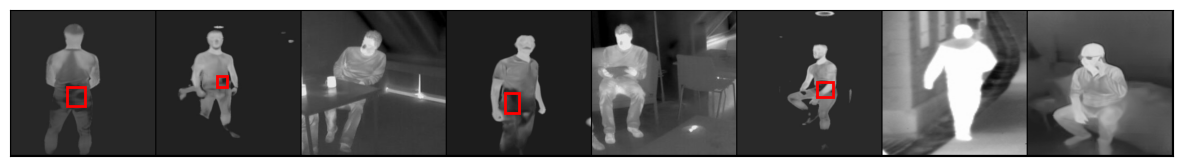

In [4]:
#plotting a grid of a single batch
def show_batch(dataLoader):
    for images, class_label, boxes in dataLoader:
        grid_img = make_grid(images, nrow=8, padding=2).permute(1, 2, 0)  # Create image grid
        fig, ax = plt.subplots(figsize=(15, 10))
        
        ax.imshow(grid_img)
        ax.set_xticks([])
        ax.set_yticks([])

        # Compute the scale factor to map box coordinates to the grid
        img_width = images.shape[3]  # Image width
        img_height = images.shape[2]  # Image height
        grid_width, grid_height = grid_img.shape[1], grid_img.shape[0]
        
        scale_x = grid_width / (8 * img_width)  # Scale for width
        scale_y = grid_height / ((batch_size // 8) * img_height)  # Scale for height

        # Loop through each image and its bounding boxes
        print(len(boxes), len(boxes[0]))
        for i in range(batch_size):
            row = i // 8  # Compute row index
            col = i % 8  # Compute column index

            x, y, width, height = boxes[0][i].tolist(),boxes[1][i].tolist(),boxes[2][i].tolist(),boxes[3][i].tolist()

            x *= img_width
            y *= img_height
            width *= img_width
            height *= img_height
            
            # Adjust bounding box coordinates to fit the grid
            x = (x * scale_x) + (col * img_width * scale_x) - 15
            y = (y * scale_y) + (row * img_height * scale_y) - 10
            width *= scale_x
            height *= scale_y
            
            # Draw the rectangle
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        plt.show()
        break  # Show only one batch

show_batch(train_dl)

### Defining the model

In [5]:
#definition for a CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        #model takes input of 256 x 256 x 1
        #make sure in_channels aligns with out_channels from the previous layer

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)

        #8 x 8 x 128 comes from sizing, the pool in each layer cut dimensionality in half, 128 is out channels
        self.fc1 = nn.Linear(in_features = (8 * 8 * 128), out_features = 64)
        self.fc2_class = nn.Linear(in_features = 64, out_features = num_classes)
        self.fc2_bbox = nn.Linear(in_features = 64, out_features = 4)

        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)



    def forward(self, input):
        #forward pass first block
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output_pool_1 = self.pool(output)

        #forward pass second block
        output = self.conv2(output_pool_1)
        output = self.bn2(output)
        output = self.relu(output)
        output_pool_2 = self.pool(output)

        #forward pass third block
        output = self.conv3(output_pool_2)
        output = self.bn3(output)
        output = self.relu(output)
        output_pool_3 = self.pool(output)

        #forward pass fourth block
        output = self.conv4(output_pool_3)
        output = self.bn4(output)
        output = self.relu(output)
        output_pool_4 = self.pool(output)

        #forward pass fifth block
        output = self.conv5(output_pool_4)
        output = self.bn5(output)
        output = self.relu(output)
        output_pool_5 = self.pool(output)


        #forward pass flattening
        output = output_pool_5.view(-1, 128 * 8 * 8)

        #forward pass fully connected layers
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)

        output_class = self.fc2_class(output)
        output_bbox = self.fc2_bbox(output)

        return output_class, output_bbox

model = Network().to(device)

#channels, height, width
summary(model,(1, 256, 256))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           9,248
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-1, 64,

### Defining Loss and Optimizer


In [6]:
#cross entropy loss
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
#adam optimizer
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Training loop of the model

In [7]:
#number of epochs and early stopping
epochs = 30
early_stopping_patience = 5
early_stopping_counter = 0

#using validation loss as the best model
best_val_loss = float('inf')
best_epoch = 0

#arrays to save each metric during training
train_loss_values = []
train_acc_values = []

val_loss_values = []
val_acc_values = []

#training loop
for epoch in range(epochs):
    #turn on training mode
    model.train()

    #storing loss and accuracy per batch
    train_losses = []
    train_acc = []

    for data, label, bbox in train_dl:
        #moving data to the right device
        data = data.to(device)
        label = label.to(device)
        bbox = np.transpose(bbox)
        bbox = torch.tensor(bbox, dtype = torch.float32, device = device)
        #print(bbox.shape)

        #clear gradients, forward pass, loss, backward and update
        optimizer.zero_grad()
        output_class, output_bbox = model(data)
        loss_class = criterion_class (output_class, label)
        loss_bbox = criterion_bbox (output_bbox, bbox)
        loss = loss_class + (loss_bbox)
        loss.backward()
        optimizer.step()

        #storing loss and accuracy over the batch
        accuracy = (output_class.argmax(dim = 1) == label).float().mean().item()
        train_losses.append(loss.item())
        train_acc.append(accuracy)
    
    #average loss and acc over the epoch
    current_epoch_loss = sum(train_losses) / len(train_losses)
    current_epoch_acc = sum(train_acc) / len(train_acc)

    #storing current epoch into overall loss and acc
    train_loss_values.append(current_epoch_loss)
    train_acc_values.append(current_epoch_acc)

    #validation testing
    #turn on evaluation mode
    model.eval()

    #storing loss and accuracy 
    val_losses = []
    val_acc = []
    
    #disabling gradient tracking
    with torch.no_grad():
        for data, label,bbox in val_dl:
            #moving data to the right device
            data = data.to(device)
            label = label.to(device)
            bbox = np.transpose(bbox)
            bbox = torch.tensor(bbox, dtype = torch.float32, device = device)
            #print(bbox)

            #running forward pass and calculating loss
            val_class, val_bbox = model(data)
            val_loss_class = criterion_class(val_class, label)
            val_loss_bbox = criterion_bbox (val_bbox, bbox)
            val_loss = val_loss_class + val_loss_bbox

            #storing loss and accuracy
            accuracy = (val_class.argmax(dim = 1) == label).float().mean().item()
            val_losses.append(val_loss.item())
            val_acc.append(accuracy)

    #averaging loss and accuracy 
    current_epoch_val_loss = sum(val_losses) / len(val_losses)
    current_epoch_val_acc = sum(val_acc) / len(val_acc)

    #storing current epoch into overall
    val_loss_values.append(current_epoch_val_loss)
    val_acc_values.append(current_epoch_val_acc)

    #checking for model improvement
    if current_epoch_val_loss < best_val_loss:
        #if best epoch, save it
        torch.save(model.state_dict(), "bounding_pistol.pth")
        
        #best epoch information
        best_val_loss = current_epoch_val_loss
        best_epoch = epoch + 1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    #output current epoch information
    if epoch % 5 == 0:
        print(f"Epoch: {epoch+1}")
        print(f"Training Accuracy: {current_epoch_acc:.3f}, Validation Accuracy: {current_epoch_val_acc:.3f}")
        print(f"Training Loss: {current_epoch_loss:.3f}, Validation Loss: {current_epoch_val_loss:.3f}")
        print(f"Current Best Epoch: {best_epoch}\n")

    #stop if not improving
    if early_stopping_counter >= early_stopping_patience:
        print(f"Stopping early after {early_stopping_patience} epochs with no improvement")
        break


Epoch: 1
Training Accuracy: 0.833, Validation Accuracy: 0.925
Training Loss: 0.578, Validation Loss: 0.624
Current Best Epoch: 1

Epoch: 6
Training Accuracy: 0.979, Validation Accuracy: 0.950
Training Loss: 0.313, Validation Loss: 0.272
Current Best Epoch: 6

Epoch: 11
Training Accuracy: 0.972, Validation Accuracy: 0.975
Training Loss: 0.241, Validation Loss: 0.253
Current Best Epoch: 9

Epoch: 16
Training Accuracy: 0.990, Validation Accuracy: 0.975
Training Loss: 0.181, Validation Loss: 0.165
Current Best Epoch: 14

Epoch: 21
Training Accuracy: 0.990, Validation Accuracy: 0.975
Training Loss: 0.129, Validation Loss: 0.177
Current Best Epoch: 19

Epoch: 26
Training Accuracy: 0.993, Validation Accuracy: 0.975
Training Loss: 0.105, Validation Loss: 0.114
Current Best Epoch: 26



### Plotting Model Training Results 

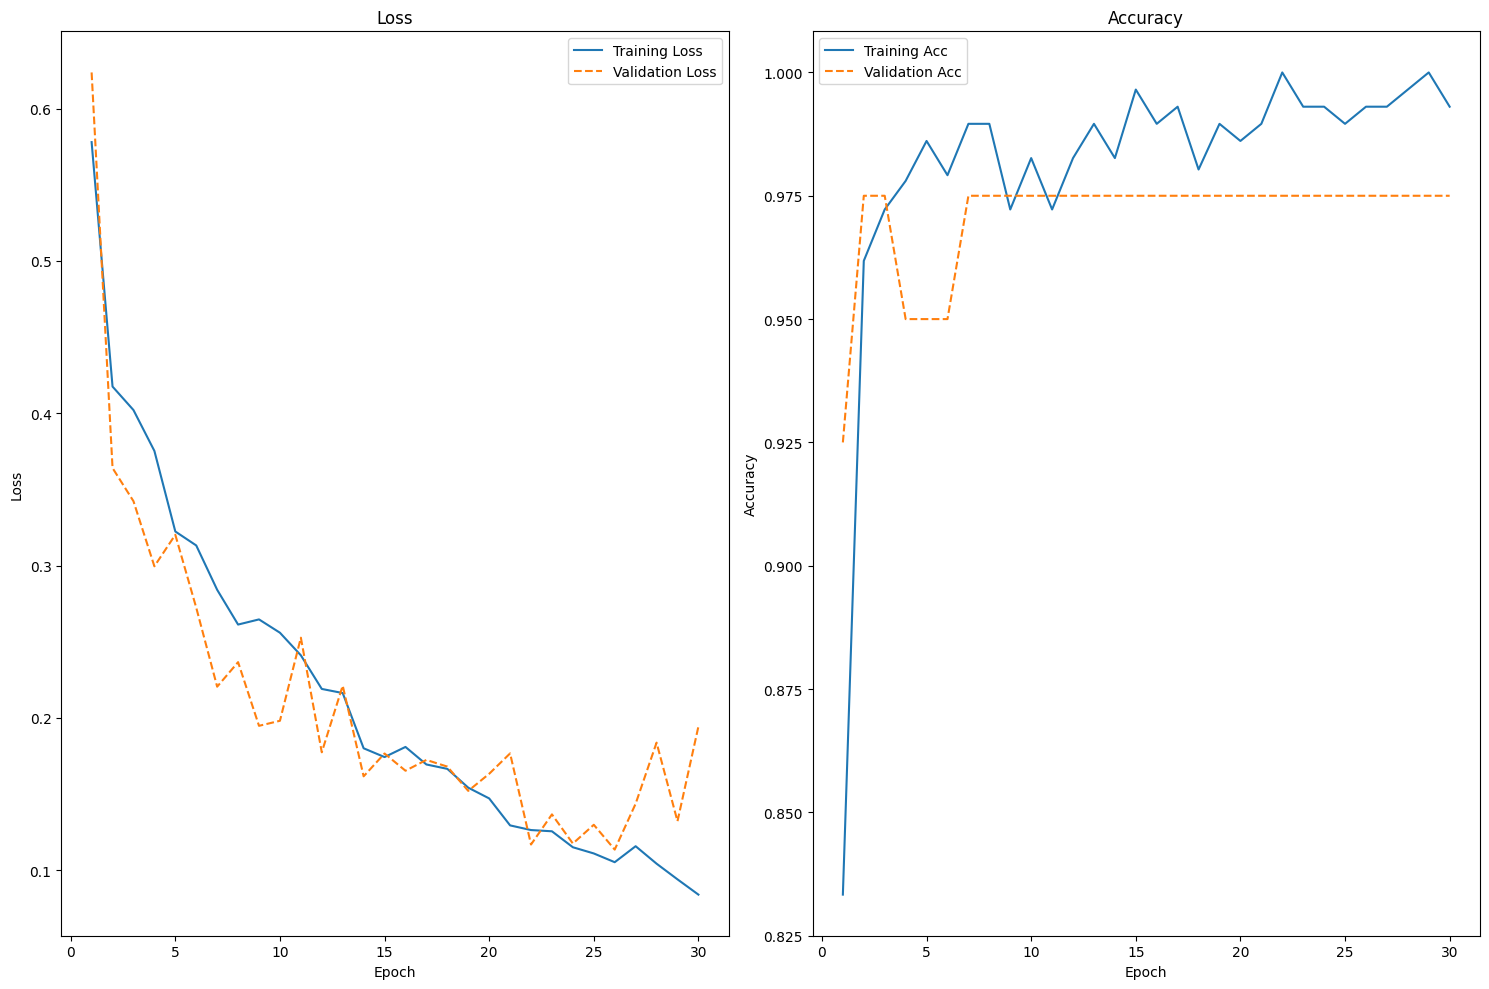

In [8]:
#epoch count
epoch_count = []
for i in range(len(train_loss_values)):
    epoch_count.append(i + 1)

#setting figure size
plt.figure(figsize = (15, 10))

#plotting loss
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, val_loss_values, label='Validation Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#plotting accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(epoch_count, train_acc_values, label='Training Acc')
plt.plot(epoch_count, val_acc_values, label='Validation Acc', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#showing figures
plt.tight_layout()
plt.show()

### Testing Model


In [9]:
#loading best saved model
model.load_state_dict(torch.load('bounding_pistol.pth', weights_only = True))

#set to evaluation mode
model.eval() 

#saving images, label, bbox for visualization in next code block
all_images, pred_labels, pred_bbox, true_labels, true_bbox = [], [], [], [], []

#disabling gradient tracking
with torch.no_grad(): 
    total_accuracy = 0.0
    total_test_loss = 0.0
    num_batches = len(test_dl)

    for data, label, bbox in test_dl:
        #loading data and labels to proper device
        data = data.to(device)
        label = label.to(device)
        bbox = np.transpose(bbox)
        bbox = torch.tensor(bbox, dtype = torch.float32, device = device)

        #forward pass, loss, accuracy calculation
        output_class, output_bbox = model(data)
        loss_class = criterion_class(output_class, label)
        loss_bbox = criterion_bbox(output_bbox, bbox)
        loss = loss_class + (loss_bbox)
        accuracy = (output_class.argmax(dim = 1) == label).float().mean()

        total_test_loss += loss.item()
        total_accuracy += accuracy.item()

        #storing individual data
        for i in range(data.shape[0]):
            all_images.append(data[i].clone().detach().cpu())
            pred_labels.append(output_class[i].argmax(dim=0).item())
            pred_bbox.append(output_bbox[i].clone().detach().cpu().tolist())
            true_labels.append(label[i].item())
            true_bbox.append(bbox[i].clone().detach().cpu().tolist())

    # Calculate the average loss and accuracy over all batches
    avg_loss = total_test_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    print(f"Test Accuracy: {avg_accuracy:.3f}")
    print(f"Test Loss : {avg_loss:.3f}")

Test Accuracy: 0.950
Test Loss : 0.116


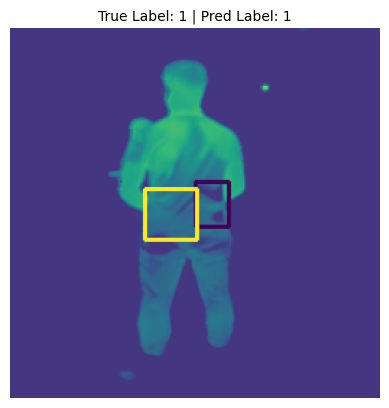

In [11]:
#print(len(all_images)) #stored as Tensor
#print(len(pred_labels))
#print(len(true_labels))
#print(len(pred_bbox), len(pred_bbox[0]))
#print(len(true_bbox), len(true_bbox[0]))

def show_image_with_bbox(image, true_label, pred_label, true_bbox, pred_bbox):
    image = image.permute(1, 2, 0).numpy()  # Convert CHW to HWC format
    image = (image * 255).astype(np.uint8)  # Rescale if needed

    # Convert bbox coordinates to pixel values
    height, width, _ = image.shape

    #converting to pixels
    true_bbox = [ int(true_bbox[0] * width), int(true_bbox[1] * height), int(true_bbox[2] * width), int(true_bbox[3] * height)]
    pred_bbox = [ int(pred_bbox[0] * width), int(pred_bbox[1] * height), int(pred_bbox[2] * width), int(pred_bbox[3] * height)]

    #converting first two coords to top left point, instead of middle of the bounding box
    true_bbox[0] = int(true_bbox[0] - (true_bbox[2] / 2))
    true_bbox[1] = int(true_bbox[1] - (true_bbox[3] / 2))
    pred_bbox[0] = int(pred_bbox[0] - (pred_bbox[2] / 2))
    pred_bbox[0] = int(pred_bbox[1] - (pred_bbox[3] / 2))

    # Draw actual bounding box (Green)
    image = cv2.rectangle(image, 
                            (true_bbox[0], true_bbox[1]), 
                            (true_bbox[0] + true_bbox[2], true_bbox[1] + true_bbox[3]), 
                            (0, 255, 0), 2)

    # Draw predicted bounding box (Red)
    image = cv2.rectangle(image, 
                            (pred_bbox[0], pred_bbox[1]), 
                            (pred_bbox[0] + pred_bbox[2], pred_bbox[1] + pred_bbox[3]), 
                            (255, 0, 0), 2)

    # Display labels
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True Label: {true_label} | Pred Label: {pred_label}", fontsize=10)
    plt.show()
#
#for i in range(len(all_images)):
for i in range(3):
    if true_labels[i] == 1 or pred_labels[i] == 1:
        show_image_with_bbox(
            all_images[i],
            true_labels[i],
            pred_labels[i],
            true_bbox[i],
            pred_bbox[i]
        )
    